# Summary

Model parameters summary:

Model with spectral normalization in all the last two residual block layers (ResBlock3 & ResBlock 4)

-   model_name: resnet18
-   input_channels: 3
-   **spectral_norm: true**
-   **drop_block: true**
-   **dropblock_prob: 0.5**
-   **dropblock_block_size: 6**
-   **dropout: false**
-   **dropout_prob: 0.3**
-   lr: 0.0001
-   weight_decay: 0.0001
-   loss_type: focal

**Results:**

This are the best results so far with LaRED Disttribution Shift Detection.

Experiment: gtsrb vs gtsrb-anomal 

- AUROC: 0.8444
- FPR95: 0.5883
- AUPR: 0.8301

Experiment: gtsrb vs cifar10

- AUROC: 0.9739
- FPR95: 0.1394
- AUPR: 0.9492

Experiment: gtsrb vs stl10

- AUROC: 0.9837
- FPR95: 0.0625
- AUPR: 0.9779

# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from datasets import GtsrbModule

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [9]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect_cea.score import get_hz_scores
from ls_ood_detect_cea.metrics import get_hz_detector_results
from ls_ood_detect_cea.metrics import get_ood_detector_results
from ls_ood_detect_cea.metrics import plot_roc_ood_detector
from ls_ood_detect_cea.metrics import plot_auprc_ood_detector
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform

# Paths

Datasets paths:

In [10]:
gtsrb_dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"
cifar10_data_path = "/media/farnez/Data/DATASETS/cifar-10/"
stl10_data_path = "/media/farnez/Data/DATASETS/stl-10/"

Experiments path:

In [18]:
exp_path = "/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/"

Resnet Classification Model Number & checkpoint:

In [19]:
exp_model_name = "resnet18_model_9"

In [20]:
gtsrb_resnet18_model_path = exp_path + exp_model_name + "/model/last.ckpt"
gtsrb_resnet18_model_path

'/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/resnet18_model_9/model/last.ckpt'

Samples Paths:

In [21]:
mc_samples_path = exp_path + exp_model_name + "/embeddings_z/mc_samples/"
mc_samples_path

'/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/resnet18_model_9/embeddings_z/mc_samples/'

In [22]:
h_z_path = exp_path + exp_model_name + "/embeddings_z/entropy/"
h_z_path

'/media/farnez/Data/EXPERIMENTS/CVPR-2024/gtsrb-classification/resnet18_model_9/embeddings_z/entropy/'

# Compute Device

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Load Entropy Values

In [33]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

In [34]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)


ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


# LaRED Score - Train Data Reference

In [19]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (

1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


In [20]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np))
gtsrb_anomal_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_h_z_cifar10_valid_samples_np, gtsrb_rn18_h_z_cifar10_test_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_h_z_stl10_valid_samples_np, gtsrb_rn18_h_z_stl10_test_samples_np))

## Build Detector

In [21]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)

## Get Scores

In [22]:
scores_gtsrb = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_h_z)

scores_gtsrb_anomal = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_anomal_h_z)

scores_cifar10 = get_hz_scores(gtsrb_ds_shift_detector, cifar10_h_z)

scores_stl10 = get_hz_scores(gtsrb_ds_shift_detector, stl10_h_z)

## Get Results

In [23]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_gtsrb_anomal.shape);
print("Experiment: gtsrb vs gtsrb-anomal");


results_gtsrb_anomal_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. gtsrb-anomal",
                                                          ind_samples_scores=scores_gtsrb,
                                                          ood_samples_scores=scores_gtsrb_anomal)

Test InD shape (4882,)
Test OoD shape (4882,)
Experiment: gtsrb vs gtsrb-anomal
AUROC: 0.8444
FPR95: 0.5883
AUPR: 0.8301


In [24]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_cifar10.shape);
print("Experiment: gtsrb vs cifar10");

results_cifar10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. cifar10",
                                                     ind_samples_scores=scores_gtsrb,
                                                     ood_samples_scores=scores_cifar10)

Test InD shape (4882,)
Test OoD shape (20000,)
Experiment: gtsrb vs cifar10
AUROC: 0.9739
FPR95: 0.1394
AUPR: 0.9492


In [25]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_stl10.shape);
print("Experiment: gtsrb vs stl10");

results_stl10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. stl10",
                                                   ind_samples_scores=scores_gtsrb,
                                                   ood_samples_scores=scores_stl10)

Test InD shape (4882,)
Test OoD shape (11000,)
Experiment: gtsrb vs stl10
AUROC: 0.9837
FPR95: 0.0625
AUPR: 0.9779


## Plot Score Values

In [26]:
df_scores_gtsrb = pd.DataFrame(scores_gtsrb, columns=["Entropy score"])
df_scores_gtsrb_anomal = pd.DataFrame(scores_gtsrb_anomal, columns=["Entropy score"])
df_scores_stl10 = pd.DataFrame(scores_stl10, columns=["Entropy score"])
df_scores_cifar10 = pd.DataFrame(scores_cifar10, columns=["Entropy score"])

df_scores_gtsrb.insert(0, "Dataset", "")
df_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_scores_stl10.insert(0, "Dataset", "")
df_scores_stl10.loc[:, "Dataset"] = "stl10"

df_scores_cifar10.insert(0, "Dataset", "")
df_scores_cifar10.loc[:, "Dataset"] = "cifar10"

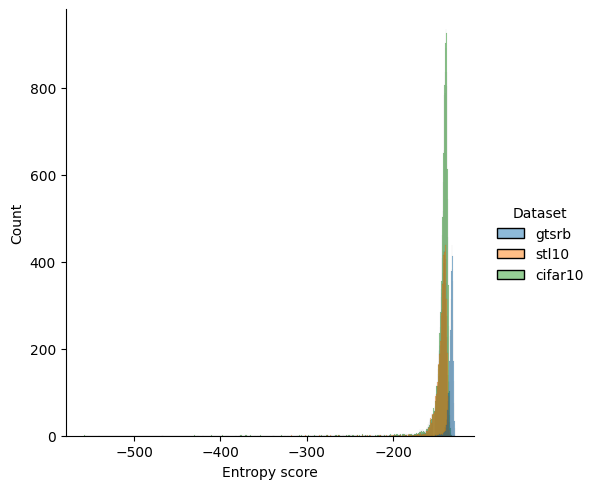

In [27]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

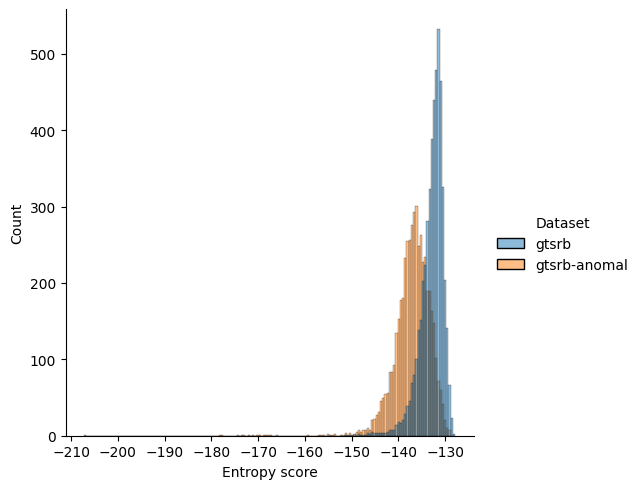

In [28]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

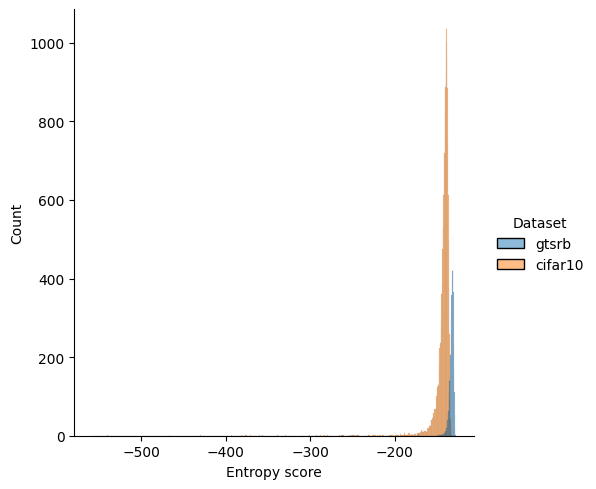

In [29]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

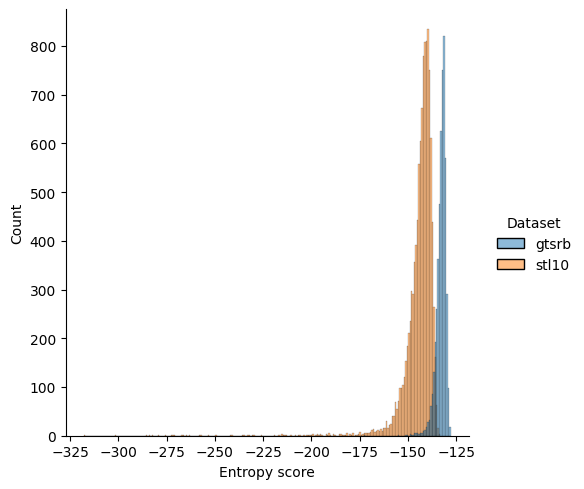

In [30]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

# Load Entropy Values

In [23]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

# LaREM Score

In [24]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);

ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);

ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);

ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)


ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


In [25]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_normal_test_samples_np))
gtsrb_anomal_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np, gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_h_z_cifar10_valid_samples_np, gtsrb_rn18_h_z_cifar10_test_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_h_z_stl10_valid_samples_np, gtsrb_rn18_h_z_stl10_test_samples_np))

## Build LaREM Distribution Shift Detector

In [26]:
from sklearn.covariance import EmpiricalCovariance

class LaREMPostprocessor:
    def __init__(self,
                 setup_flag: bool = False,
                 get_2d_rep_mean: bool = False):

        self.setup_flag = setup_flag
        self.get_2d_rep_mean = get_2d_rep_mean
        self.feats_mean = None
        self.precision = None

    def setup(self,
              ind_feats: np.ndarray):
        
        if not self.setup_flag:
            # estimate mean and variance from training set
            print('\n Estimating mean and variance from training set...')

            self.feats_mean = ind_feats.mean(0)
            self.feats_mean = np.mean(ind_feats, 0, keepdims=True)
            
            self.centered_data = ind_feats - self.feats_mean
              
            group_lasso = EmpiricalCovariance(assume_centered=False)
            group_lasso.fit(self.centered_data)
            
            self.precision = group_lasso.precision_
            
            self.setup_flag = True
            # we need to use:
            # self.feats_mean & self.precision
        else:
            pass

    def postprocess(self,
                    ood_feats: np.ndarray):
           
        diff = ood_feats - self.feats_mean
        conf_score = -np.diag(np.matmul(np.matmul(diff, self.precision), np.transpose(diff)))

        return conf_score

In [27]:
gtsrb_rn18_larem_detector = LaREMPostprocessor()

In [28]:
gtsrb_rn18_larem_detector.setup(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)


 Estimating mean and variance from training set...


In [29]:
ic(gtsrb_rn18_larem_detector.feats_mean.shape);
ic(gtsrb_rn18_larem_detector.precision.shape);

ic| gtsrb_rn18_larem_detector.feats_mean.shape: (1, 128)


ic| gtsrb_rn18_larem_detector.precision.shape: (128, 128)


## Get Scores

In [30]:
ic(gtsrb_h_z.shape);
ic(gtsrb_anomal_h_z.shape);
ic(cifar10_h_z.shape);
ic(stl10_h_z.shape);

ic| gtsrb_h_z.shape: (4882, 128)


ic| gtsrb_anomal_h_z.shape: (4882, 128)
ic| cifar10_h_z.shape: (20000, 128)
ic| stl10_h_z.shape: (11000, 128)


In [31]:
ind_gtsrb_larem_score = gtsrb_rn18_larem_detector.postprocess(gtsrb_h_z)
ic(ind_gtsrb_larem_score.shape);

ood_gtsrb_anomal_larem_score = gtsrb_rn18_larem_detector.postprocess(gtsrb_anomal_h_z)
ic(ood_gtsrb_anomal_larem_score.shape);

ood_cifar10_larem_score = gtsrb_rn18_larem_detector.postprocess(cifar10_h_z)
ic(ood_cifar10_larem_score.shape);

ood_stl10_larem_score = gtsrb_rn18_larem_detector.postprocess(stl10_h_z)
ic(ood_stl10_larem_score.shape);

ic| ind_gtsrb_larem_score.shape: (4882,)
ic| ood_gtsrb_anomal_larem_score.shape: (4882,)
ic| ood_cifar10_larem_score.shape: (20000,)
ic| ood_stl10_larem_score.shape: (11000,)


## Get Results

In [32]:
print("\ngtsrb-normal vs. gtsrb-anomal:")
print("Test InD shape", ind_gtsrb_larem_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_larem_score.shape);

results_gtsrb_anomal = get_hz_detector_results(detect_exp_name="gtsrb-normal vs. gtsrb-anomal",
                                               ind_samples_scores=ind_gtsrb_larem_score,
                                               ood_samples_scores=ood_gtsrb_anomal_larem_score)

print("\ngtsrb-normal vs. cifar10:")
print("Test InD shape", ind_gtsrb_larem_score.shape);
print("Test OoD shape", ood_cifar10_larem_score.shape);

results_cifar10 = get_hz_detector_results(detect_exp_name="gtsrb-normal vs. cifar10",
                                          ind_samples_scores=ind_gtsrb_larem_score,
                                          ood_samples_scores=ood_cifar10_larem_score)

print("\ngtsrb-normal vs. stl10:")
print("Test InD shape", ind_gtsrb_larem_score.shape);
print("Test OoD shape", ood_stl10_larem_score.shape);

results_stl10 = get_hz_detector_results(detect_exp_name="gtsrb-normal vs. stl10",
                                        ind_samples_scores=ind_gtsrb_larem_score,
                                        ood_samples_scores=ood_stl10_larem_score)


gtsrb-normal vs. gtsrb-anomal:
Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.7733
FPR95: 0.7438
AUPR: 0.7563

gtsrb-normal vs. cifar10:
Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9471
FPR95: 0.2986
AUPR: 0.8757

gtsrb-normal vs. stl10:
Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9641
FPR95: 0.1974
AUPR: 0.9426


# Load Entropy Values from Normalized Embeddings Z

In [20]:
gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_norm_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_norm_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_norm_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_norm_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_norm_samples_np.npy')

In [21]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_norm_samples_np.shape);

ic

| gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np.shape: (7120, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_norm_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_norm_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_norm_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_norm_samples_np.shape: (8000, 128)


# LaRED Score - Train Data Reference

In [22]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np, gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np))
gtsrb_anomal_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np, gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_h_z_cifar10_valid_norm_samples_np, gtsrb_rn18_h_z_cifar10_test_norm_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_h_z_stl10_valid_norm_samples_np, gtsrb_rn18_h_z_stl10_test_norm_samples_np))

## Build Detector

In [23]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np)

## Get Scores

In [24]:
scores_gtsrb = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_h_z)

scores_gtsrb_anomal = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_anomal_h_z)

scores_cifar10 = get_hz_scores(gtsrb_ds_shift_detector, cifar10_h_z)

scores_stl10 = get_hz_scores(gtsrb_ds_shift_detector, stl10_h_z)

## Get Results

In [25]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_gtsrb_anomal.shape);
print("Experiment: gtsrb vs gtsrb-anomal");


results_gtsrb_anomal_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. gtsrb-anomal",
                                                          ind_samples_scores=scores_gtsrb,
                                                          ood_samples_scores=scores_gtsrb_anomal)

Test InD shape (4882,)
Test OoD shape (4882,)
Experiment: gtsrb vs gtsrb-anomal
AUROC: 0.8128
FPR95: 0.6673
AUPR: 0.7956


In [26]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_cifar10.shape);
print("Experiment: gtsrb vs cifar10");

results_cifar10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. cifar10",
                                                     ind_samples_scores=scores_gtsrb,
                                                     ood_samples_scores=scores_cifar10)

Test InD shape (4882,)
Test OoD shape (20000,)
Experiment: gtsrb vs cifar10
AUROC: 0.9606
FPR95: 0.2334
AUPR: 0.9158


In [27]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_stl10.shape);
print("Experiment: gtsrb vs stl10");

results_stl10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. stl10",
                                                   ind_samples_scores=scores_gtsrb,
                                                   ood_samples_scores=scores_stl10)

Test InD shape (4882,)
Test OoD shape (11000,)
Experiment: gtsrb vs stl10
AUROC: 0.9750
FPR95: 0.1265
AUPR: 0.9636


## Plot Score Values

In [28]:
df_scores_gtsrb = pd.DataFrame(scores_gtsrb, columns=["Entropy score"])
df_scores_gtsrb_anomal = pd.DataFrame(scores_gtsrb_anomal, columns=["Entropy score"])
df_scores_stl10 = pd.DataFrame(scores_stl10, columns=["Entropy score"])
df_scores_cifar10 = pd.DataFrame(scores_cifar10, columns=["Entropy score"])

df_scores_gtsrb.insert(0, "Dataset", "")
df_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_scores_stl10.insert(0, "Dataset", "")
df_scores_stl10.loc[:, "Dataset"] = "stl10"

df_scores_cifar10.insert(0, "Dataset", "")
df_scores_cifar10.loc[:, "Dataset"] = "cifar10"

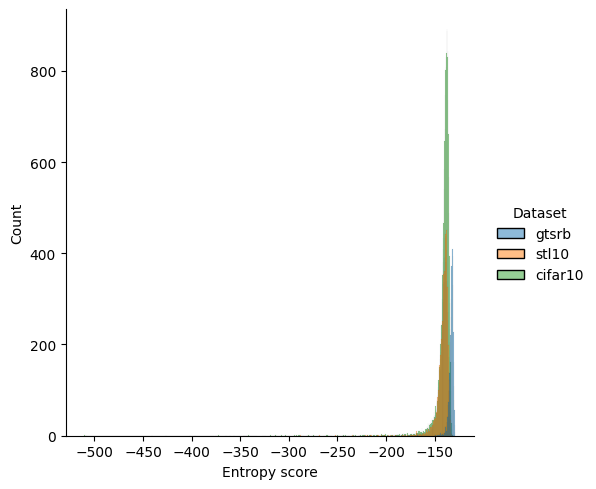

In [29]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

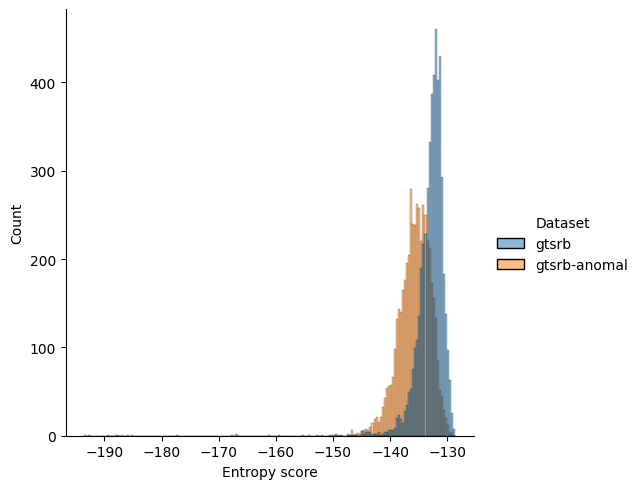

In [30]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

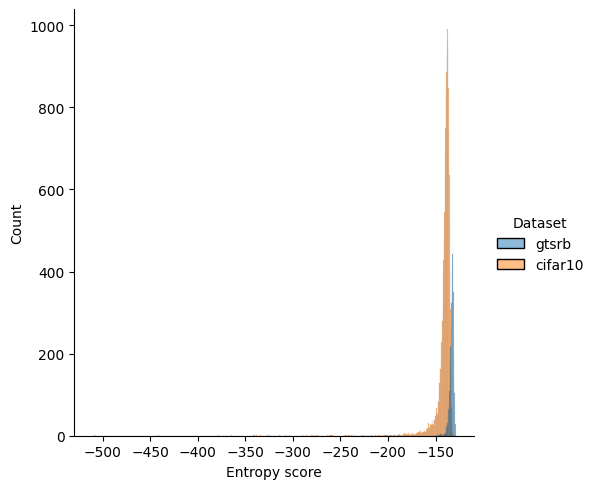

In [31]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

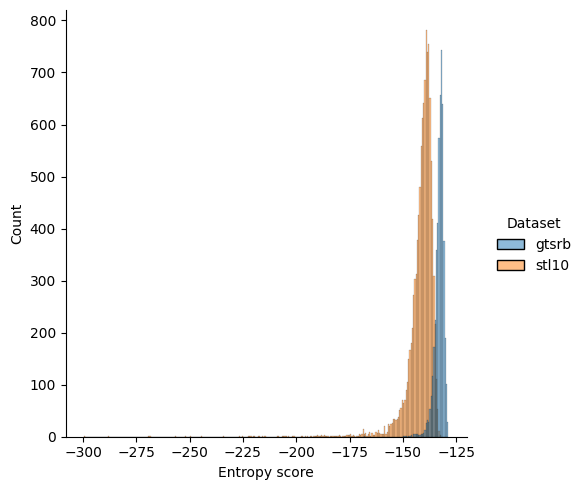

In [32]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

# Normalize Entropy Values

In [36]:
gtsrb_rn18_h_z_gtsrb_normal_train_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_normal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.npy')

gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.npy')
gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_h_z_cifar10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_h_z_cifar10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_h_z_stl10_valid_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_h_z_stl10_test_samples_np = np.load(h_z_path + 'gtsrb_rn18_h_z_stl10_test_samples_np.npy')

ic(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_samples_np.shape: (8000, 128)


In [37]:
normalizer = lambda x: x / (np.linalg.norm(x, ord=2, axis=-1, keepdims=True) + 1e-10)

In [38]:
gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np = normalizer(gtsrb_rn18_h_z_gtsrb_normal_train_samples_np)
gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np = normalizer(gtsrb_rn18_h_z_gtsrb_normal_valid_samples_np)
gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np = normalizer(gtsrb_rn18_h_z_gtsrb_normal_test_samples_np)

gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np = normalizer(gtsrb_rn18_h_z_gtsrb_anomal_valid_samples_np)
gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np = normalizer(gtsrb_rn18_h_z_gtsrb_anomal_test_samples_np)

gtsrb_rn18_h_z_cifar10_valid_norm_samples_np = normalizer(gtsrb_rn18_h_z_cifar10_valid_samples_np)
gtsrb_rn18_h_z_cifar10_test_norm_samples_np = normalizer(gtsrb_rn18_h_z_cifar10_test_samples_np)

gtsrb_rn18_h_z_stl10_valid_norm_samples_np = normalizer(gtsrb_rn18_h_z_stl10_valid_samples_np)
gtsrb_rn18_h_z_stl10_test_norm_samples_np = normalizer(gtsrb_rn18_h_z_stl10_test_samples_np)

In [39]:
ic(gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_cifar10_test_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_valid_norm_samples_np.shape);
ic(gtsrb_rn18_h_z_stl10_test_norm_samples_np.shape);

ic| gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np.shape: (7120, 128)


ic| gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_h_z_cifar10_valid_norm_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_cifar10_test_norm_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_h_z_stl10_valid_norm_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_h_z_stl10_test_norm_samples_np.shape: (8000, 128)


# LaRED Score - Train Data Reference

In [40]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_normal_valid_norm_samples_np, gtsrb_rn18_h_z_gtsrb_normal_test_norm_samples_np))
gtsrb_anomal_h_z = np.concatenate((gtsrb_rn18_h_z_gtsrb_anomal_valid_norm_samples_np, gtsrb_rn18_h_z_gtsrb_anomal_test_norm_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_h_z_cifar10_valid_norm_samples_np, gtsrb_rn18_h_z_cifar10_test_norm_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_h_z_stl10_valid_norm_samples_np, gtsrb_rn18_h_z_stl10_test_norm_samples_np))

## Build Detector

In [41]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=gtsrb_rn18_h_z_gtsrb_normal_train_norm_samples_np)

## Get Scores

In [42]:
scores_gtsrb = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_h_z)

scores_gtsrb_anomal = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_anomal_h_z)

scores_cifar10 = get_hz_scores(gtsrb_ds_shift_detector, cifar10_h_z)

scores_stl10 = get_hz_scores(gtsrb_ds_shift_detector, stl10_h_z)

## Get Results

In [43]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_gtsrb_anomal.shape);
print("Experiment: gtsrb vs gtsrb-anomal");


results_gtsrb_anomal_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. gtsrb-anomal",
                                                          ind_samples_scores=scores_gtsrb,
                                                          ood_samples_scores=scores_gtsrb_anomal)

Test InD shape (4882,)
Test OoD shape (4882,)
Experiment: gtsrb vs gtsrb-anomal
AUROC: 0.3244
FPR95: 0.9887
AUPR: 0.3986


In [44]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_cifar10.shape);
print("Experiment: gtsrb vs cifar10");

results_cifar10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. cifar10",
                                                     ind_samples_scores=scores_gtsrb,
                                                     ood_samples_scores=scores_cifar10)

Test InD shape (4882,)
Test OoD shape (20000,)
Experiment: gtsrb vs cifar10
AUROC: 0.4384
FPR95: 0.9408
AUPR: 0.1732


In [45]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_stl10.shape);
print("Experiment: gtsrb vs stl10");

results_stl10_validation = get_hz_detector_results(detect_exp_name="gtsrb vs. stl10",
                                                   ind_samples_scores=scores_gtsrb,
                                                   ood_samples_scores=scores_stl10)

Test InD shape (4882,)
Test OoD shape (11000,)
Experiment: gtsrb vs stl10
AUROC: 0.4446
FPR95: 0.9541
AUPR: 0.2802


## Plot Score Values

In [46]:
df_scores_gtsrb = pd.DataFrame(scores_gtsrb, columns=["Entropy score"])
df_scores_gtsrb_anomal = pd.DataFrame(scores_gtsrb_anomal, columns=["Entropy score"])
df_scores_stl10 = pd.DataFrame(scores_stl10, columns=["Entropy score"])
df_scores_cifar10 = pd.DataFrame(scores_cifar10, columns=["Entropy score"])

df_scores_gtsrb.insert(0, "Dataset", "")
df_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_scores_stl10.insert(0, "Dataset", "")
df_scores_stl10.loc[:, "Dataset"] = "stl10"

df_scores_cifar10.insert(0, "Dataset", "")
df_scores_cifar10.loc[:, "Dataset"] = "cifar10"

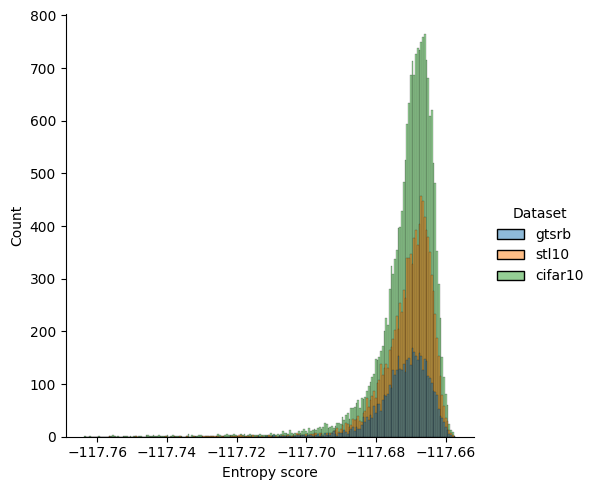

In [47]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

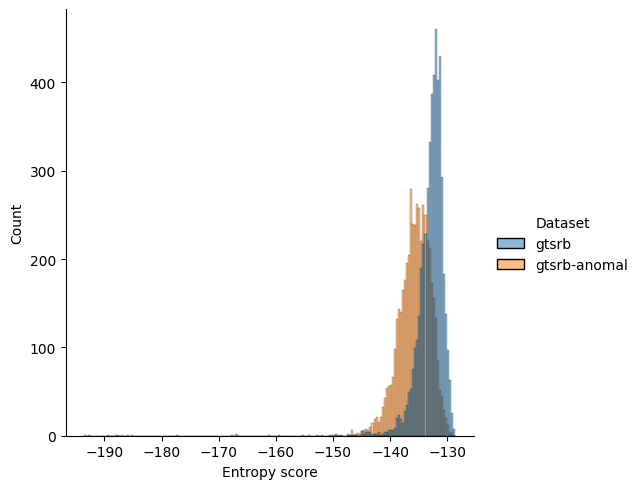

In [ ]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

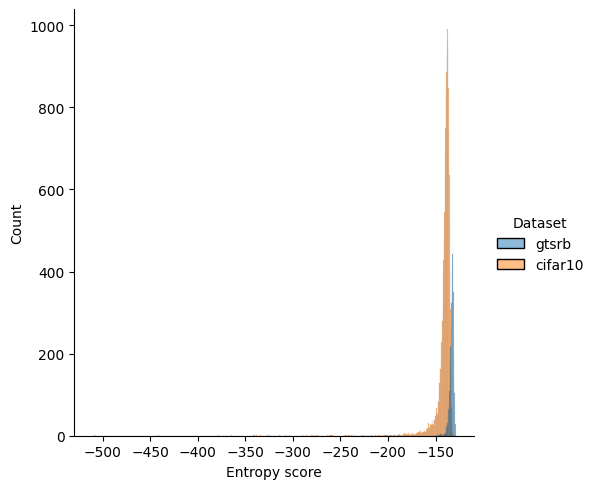

In [ ]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

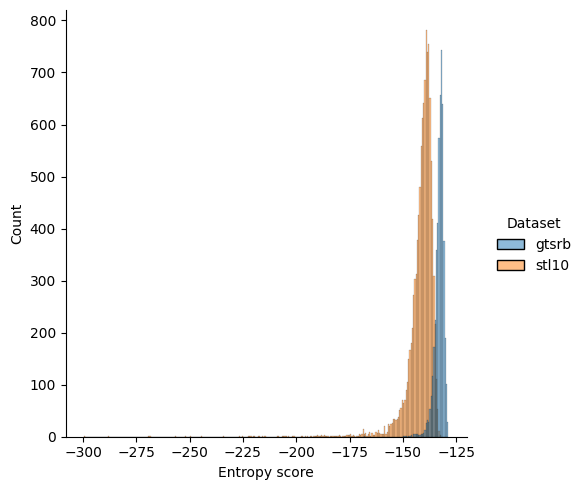

In [ ]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()